## 1. Preparación del ambiente

In [ ]:
# Instalación de paquetes en la VM de Colab
!python -m pip install wordcloud
!python -m nltk.downloader all

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_t

In [ ]:
# Librerías Python
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output

import seaborn as sns
import json
import requests
import gzip




## 2. Pre procesamiento de datos

### 2.1 Carga del dataset

In [ ]:
#!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Musical_Instruments_5.json.gz
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Software_5.json.gz

--2022-08-08 17:44:17--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Software_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5339013 (5.1M) [application/octet-stream]
Saving to: ‘Software_5.json.gz.1’

Software_5.json.gz. 100%[===================>]   5.09M  19.5MB/s    in 0.3s    

2022-08-08 17:44:17 (19.5 MB/s) - ‘Software_5.json.gz.1’ saved [5339013/5339013]



In [ ]:
# Creación del Data Frame a partir del Data Set. Ya que el data set es grande, se elige la categoría "Musical Instruments" para optimizar el ejercicio.
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Software_5.json.gz')

In [ ]:
# Se verifica el contenido
df.sample(5)

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
7995,1.0,False,"12 4, 2013",A2QFUMSDNMZY1H,B00EOI2SR2,{'Format:': ' Software'},Patriot,I could not get X6 to install properly and Cor...,Compatibility Issues with Microsoft KB2670838 ...,1386115200,19,NaN
8775,5.0,True,"05 2, 2015",A25NDDJD0UUALR,B00FZ0FK0U,{'Format:': ' Software Download'},Christopher,Look no further for security software for mac ...,Excellent,1430524800,NaN,NaN
3364,5.0,False,"09 20, 2008",A3JJNSW1XHXX9B,B0018EI3I8,NaN,HealthIT,"Kaspersky used to be more geared to admins, co...","Great for the PC beginner, or PC GOD! This is ...",1221868800,11,NaN
5379,4.0,False,"05 11, 2012",A2I3XS9TO93Q0F,B004PBG8EC,{'Format:': ' Software'},Michael Meredith,"I know, you can get directions for free to get...",Great planner for a road trip!,1336694400,NaN,NaN
9563,4.0,True,"02 11, 2015",A2IOGHTCJ3QAHU,B00M9GTEPA,{'Platform:': ' PC Disc'},Tall Timbers,I've been using Quicken since 1992 when I got ...,Quicken is a Powerful Tool if You're Dedicated...,1423612800,NaN,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12805 entries, 0 to 12804
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         12805 non-null  float64
 1   verified        12805 non-null  bool   
 2   reviewTime      12805 non-null  object 
 3   reviewerID      12805 non-null  object 
 4   asin            12805 non-null  object 
 5   style           7161 non-null   object 
 6   reviewerName    12796 non-null  object 
 7   reviewText      12804 non-null  object 
 8   summary         12799 non-null  object 
 9   unixReviewTime  12805 non-null  int64  
 10  vote            3902 non-null   object 
 11  image           71 non-null     object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 1.2+ MB


Reduzco los datos a trabajar

In [ ]:
# Dejo sólo las columnas necesarias
df = df[['reviewText','overall']]
# Elimino valores nan
df = df.dropna()

Se descarta el valor neutral 3.0 y se agrega la columna con valores binarios positive/negative

In [ ]:
# Se descarta el valor neutral 3.0
df = df[df.overall != 3.0]

In [ ]:
# Se define una nueva columna con valores positive (rating 4 o 5) y negative (rating 1 o 2)
def sentiment(n):return "positive" if n >= 4.0 else "negative"
df['sentiment'] = df['overall'].apply(sentiment)

In [ ]:
#Transformar todas las palabras a minúsculas
df['reviewText'] = df['reviewText'].apply(lambda x: x.lower())

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


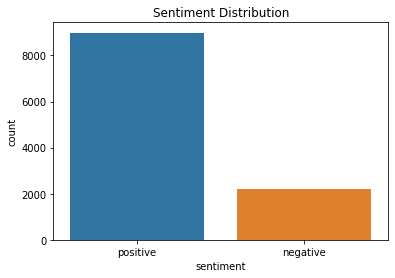

In [ ]:
ax = plt.axes()
sns.countplot(df.sentiment, ax=ax)
ax.set_title('Sentiment Distribution')
plt.show()

In [ ]:
#Eliminar todos los caracteres no alfanuméricos
df['reviewText'] = df['reviewText'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [ ]:
# Analicemos la cantidad de datos positivos y negativos que tenemos
print(df[ df['sentiment'] == 'positive'].size)
print(df[ df['sentiment'] == 'negative'].size)

26961
6657


## Tokenization

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Se limita a 2000 features por eficiencia
max_features = 250
#Inicializo el Tokenizer
tokenizer = Tokenizer(num_words=max_features, split=' ')
#Entrenamiento
tokenizer.fit_on_texts(df['reviewText'].values)
#texts_to_sequences transforma el input en arrays numéricos
X = tokenizer.texts_to_sequences(df['reviewText'].values)
#pads_sequences transforma las secuencias al mismo largo
X = pad_sequences(X)

In [ ]:
X.shape

(11206, 2671)

## Armado de la red neuronal

Capas de la red:

* Embedding: Utilizada para bajar la dimensionalidad
* LSTM
* Capa Densa con función de activación softmax y la cantidad de nodos necesarios para el problema de clasificación

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout

embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.5))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2671, 128)         32000     
                                                                 
 dropout_1 (Dropout)         (None, 2671, 128)         0         
                                                                 
 lstm_1 (LSTM)               (None, 196)               254800    
                                                                 
 dense_1 (Dense)             (None, 2)                 394       
                                                                 
Total params: 287,194
Trainable params: 287,194
Non-trainable params: 0
_________________________________________________________________


## Entrenamiento

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

Se preparan los datos para el entrenamiento

In [ ]:
Y = pd.get_dummies(df['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7508, 2671) (7508, 2)
(3698, 2671) (3698, 2)


Entrenamiento del modelo

In [ ]:
batch_size = 16
model.fit(X_train, Y_train, epochs = 2, batch_size=batch_size, verbose = 2)

Epoch 1/2
470/470 - 5011s - loss: 0.4515 - accuracy: 0.8026 - 5011s/epoch - 11s/step
Epoch 2/2
470/470 - 4855s - loss: 0.4017 - accuracy: 0.8235 - 4855s/epoch - 10s/step


## Evaluación de resultados

In [ ]:
#Tomo 1500 datos para la validación y test
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]

In [ ]:
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("Score: %.2f" % (score))
print("Acc: %.2f" % (acc))

138/138 - 77s - loss: 0.3818 - accuracy: 0.8294 - 77s/epoch - 557ms/step
Score: 0.38
Acc: 0.83


Utilizo el método predict para verificar si el comportamiento con los tweets negativos es el mismo que con los positivos o si hay un sesgo en los datos.

In [ ]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1

print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

1/1 - 1s - 849ms/epoch - 849ms/step
1/1 - 1s - 618ms/epoch - 618ms/step
1/1 - 1s - 627ms/epoch - 627ms/step
1/1 - 1s - 625ms/epoch - 625ms/step
1/1 - 1s - 622ms/epoch - 622ms/step
1/1 - 1s - 613ms/epoch - 613ms/step
1/1 - 1s - 624ms/epoch - 624ms/step
1/1 - 1s - 596ms/epoch - 596ms/step
1/1 - 1s - 609ms/epoch - 609ms/step
1/1 - 1s - 596ms/epoch - 596ms/step
1/1 - 1s - 607ms/epoch - 607ms/step
1/1 - 1s - 606ms/epoch - 606ms/step
1/1 - 1s - 598ms/epoch - 598ms/step
1/1 - 1s - 611ms/epoch - 611ms/step
1/1 - 1s - 607ms/epoch - 607ms/step
1/1 - 1s - 598ms/epoch - 598ms/step
1/1 - 1s - 609ms/epoch - 609ms/step
1/1 - 1s - 595ms/epoch - 595ms/step
1/1 - 1s - 608ms/epoch - 608ms/step
1/1 - 1s - 606ms/epoch - 606ms/step
1/1 - 1s - 594ms/epoch - 594ms/step
1/1 - 1s - 603ms/epoch - 603ms/step
1/1 - 1s - 598ms/epoch - 598ms/step
1/1 - 1s - 598ms/epoch - 598ms/step
1/1 - 1s - 607ms/epoch - 607ms/step
1/1 - 1s - 595ms/epoch - 595ms/step
1/1 - 1s - 626ms/epoch - 626ms/step
1/1 - 1s - 595ms/epoch - 595